# Summary

This notebook compares several clustering algorithms on simulated data, both from execution time and ARI scores points of view

In [2]:
import sys
sys.path.append("..")

#GPU configuration
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scripts.data_generator as data_generator
import scripts.feature_ranking as feature_ranking
import scripts.features_2d as features_2d
import scripts.ga as ga
import scripts.ga_evaluation as ga_evaluation
import scripts.main as main
from IPython import get_ipython
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN, MeanShift, OPTICS
from sklearn.metrics.cluster import (adjusted_rand_score, silhouette_score, 
                                     davies_bouldin_score, calinski_harabasz_score)
import scripts.validation_open_ensembles as voe
from sklearn.cluster import SpectralClustering, AffinityPropagation
import hdbscan
from sklearn import mixture
from tqdm import tqdm
import seaborn as sns
import time
import string
plt.ion()
plt.show()

random_state=4
random.seed( random_state )
np.random.seed(random_state)

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Utility functions

In [3]:
def get_scores(input_data, pred, truth):

    if len(np.unique(pred)) == 1 or len(np.unique(pred))>= len(pred) -1:
        sil = 0
        db = 9
    else:
        sil = silhouette_score(input_data, pred)
        db = davies_bouldin_score(input_data, pred)
    ari = adjusted_rand_score(truth, pred)
    
    v = voe.validation(input_data, pred)
    arl = v.adapted_ratkowsky_lance()
    return sil, db, arl, ari

def getOptimalEpsDBSCAN(data, n_neighbors=3, plot = True, windowSize = 5):
    """
    Estimate the optimal epsilon for dbscan as an elbow plot
    https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    """
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    scalingFactor = 10
    
#     windowSize = len(distances)//20
    
    elbowDF = pd.DataFrame()
    elbowDF['orig']= distances
    elbowDF['rma'] = elbowDF['orig'].rolling(window = windowSize, center = True, min_periods = 1).mean()
    elbowDF['rma'] = preprocessing.MinMaxScaler().fit_transform(elbowDF[['rma']]).ravel() * elbowDF.shape[0]
    elbowDF['diff'] = elbowDF['rma'].diff(1)
    elbowDF['diff'] = elbowDF['diff'].rolling(window = windowSize, center = True, min_periods = 1).mean()
    kneePoint = np.where(elbowDF['diff'].values>1)[0][0] #+ windowSize
    eps = scalingFactor * elbowDF['orig'].values[kneePoint]
    
    # from kneed import KneeLocator

    # kneedle = KneeLocator(np.arange(elbowDF.shape[0]), elbowDF['orig'].values, S=1.0, 
    #                       curve='convex', direction='increasing')
    # eps = elbowDF['orig'].values[kneedle.knee]
    # print(kneedle.knee, elbowDF['orig'].values[kneedle.knee])
    # kneedle.plot_knee()
    
    if plot:
        plt.figure()
        plt.title(f'eps : {eps}')
        plt.plot(np.arange(len(distances)), scalingFactor * distances)
        plt.grid()
        plt.axvline(kneePoint, c = 'red')
    return eps


In [ ]:
n_clusters_per_subpace = [5, 15, 30]
cluster_std = 0.05
n_uniform_features=100
n_normal_features=100
n_neg_binomial = 100
n_gamma = 100
n_redundant_clusters = 0
n_redundant_cluster_size = 0
data, best_subspaces, truths = data_generator.make_data_for_ga(
                     n_clusters_per_subpace,
                     cluster_std=[0.01, 0.01, 0.01],
                     n_uniform_features=3,
                     n_normal_features=3,
                     n_neg_binomial=4,
                     n_gamma=3,
                     n_beta=7,
                     random_redundant=True,
                     n_redundant=5,
                     n_outlier_features=2,
                     n_cutoff=0,
                     n_bimodal_features=2,
                     min_subspace_features=5,
                     max_subspace_features=6,
                     n_samples=None,
                     plot=True)


imp_f = np.concatenate(best_subspaces)
data.shape, imp_f, best_subspaces

In [ ]:
results = pd.DataFrame(columns = ["Cluster std", "subspace", "Algorithm", "Nb Clusters", "k",  "Silhouette", 
                                  "Davies Bouldin", "Ratkovski Lance", "ARI", "Execution time", 
                                  "Nb features", "Nb samples"])
n_cluster_candidates = [[3, 5, 7], [10, 15, 20], [30, 40, 50]]
cluster_std=[0.01, 0.06, 0.12]
n_clusters_per_subpace = [5, 15, 30]
nb_features = [3, 10, 20]

for n_samples in [450, 900, 1300]:
    for nf in nb_features:

        for std in cluster_std:
            data, best_subspaces, truths = data_generator.make_data_for_ga(
                                 n_clusters_per_subpace,
                                 cluster_std=[std, std, std],
                                 n_uniform_features=3,
                                 n_normal_features=3,
                                 n_neg_binomial=4,
                                 n_gamma=3,
                                 n_beta=7,
                                 random_redundant=True,
                                 n_redundant=5,
                                 n_outlier_features=2,
                                 n_cutoff=0,
                                 n_bimodal_features=2,
                                 min_subspace_features=nf,
                                 max_subspace_features=nf + 1,
                                 n_samples=n_samples,
                                 plot=False)

            for i, subspace in enumerate(best_subspaces):
                input_data = data[:, subspace]

                for n in n_cluster_candidates[i]:
                    t1= time.time()
                    pred = KMeans(n_clusters=n, random_state=0).fit(input_data).labels_
                    t2 = time.time()
                    sil, db, arl, ari = get_scores(input_data, pred, truths[i])
                    results.loc[results.shape[0]] = [std, i, "KMeans", n_clusters_per_subpace[i] ,
                                                     n, sil, db, arl, ari , t2-t1, nf, n_samples]

                    t1= time.time()
                    pred = SpectralClustering(n_clusters=n, random_state=0).fit(input_data).labels_
                    t2 = time.time()
                    sil, db, arl, ari = get_scores(input_data, pred, truths[i])
                    results.loc[results.shape[0]] = [std, i, "Spectral Clustering", n_clusters_per_subpace[i] ,
                                                     n, sil, db, arl, ari, t2-t1 , nf, n_samples]

                    t1= time.time()
                    gmm = mixture.GaussianMixture(n_components=n,
                                                      covariance_type="full", random_state=0)
                    
                    pred = gmm.fit_predict(input_data)
                    t2 = time.time()
                    sil, db, arl, ari = get_scores(input_data, pred, truths[i])
                    results.loc[results.shape[0]] = [std, i, "GMM", n_clusters_per_subpace[i] ,
                                                     n, sil, db, arl, ari , t2-t1, nf, n_samples]

                t1= time.time()
                pred = MeanShift(bandwidth=0.2).fit(input_data).labels_
                t2 = time.time()
                sil, db, arl, ari = get_scores(input_data, pred, truths[i])
                results.loc[results.shape[0]] = [std, i, "MeanShift", n_clusters_per_subpace[i] ,
                                    n_clusters_per_subpace[i] , sil, db, arl, ari , t2-t1, nf, n_samples]

                t1= time.time()
                pred =  hdbscan.HDBSCAN(min_cluster_size =10).fit(input_data).labels_
                t2 = time.time()
                sil, db, arl, ari = get_scores(input_data, pred, truths[i])
                results.loc[results.shape[0]] = [std, i, "HDBSCAN", n_clusters_per_subpace[i] ,
                                    n_clusters_per_subpace[i] , sil, db, arl, ari, t2-t1 , nf, n_samples]

                t1= time.time()
                eps = getOptimalEpsDBSCAN(input_data, n_neighbors=4, plot = False, windowSize = 5)
                pred =  DBSCAN(eps =eps, min_samples=10).fit(input_data).labels_
                t2 = time.time()
                sil, db, arl, ari = get_scores(input_data, pred, truths[i])
                results.loc[results.shape[0]] = [std, i, "DBSCAN", n_clusters_per_subpace[i] ,
                                        n_clusters_per_subpace[i] , sil, db, arl, ari , t2-t1, nf, n_samples]

results.to_pickle("../data/cluster_analysis/results.pkl")

# Analyze and plot results

## Start from here if the results file has been generated

In [3]:
letters = list(string.ascii_lowercase)
results = pd.read_pickle("../data/cluster_analysis/results.pkl")
results = results[results["Algorithm"]!= "DBSCAN"]
results.sort_values(by = "Execution time")

,Cluster std,subspace,Algorithm,Nb Clusters,k,Silhouette,Davies Bouldin,Ratkovski Lance,ARI,Execution time,Nb features,Nb samples
254,0.06,0,GMM,5,3,0.538265,0.843132,0.193957,0.613264,0.005870,20,450
650,0.01,0,GMM,5,3,0.699068,0.581566,0.200010,0.614654,0.006055,3,1300
182,0.12,0,GMM,5,3,0.381289,1.007212,0.162190,0.480524,0.006798,10,450
185,0.12,0,GMM,5,5,0.433454,0.944692,0.135092,1.000000,0.006855,10,450
506,0.12,0,GMM,5,3,0.377209,1.151555,0.165841,0.614329,0.006959,10,900
...,...,...,...,...,...,...,...,...,...,...,...,...
801,0.06,0,MeanShift,5,5,0.042568,1.504981,0.023998,0.862345,6.517273,10,1300
741,0.12,1,MeanShift,15,15,0.409946,0.835360,0.110109,0.317659,6.980791,3,1300
429,0.12,2,MeanShift,30,30,0.251254,1.135779,0.088984,0.072160,9.545670,3,900
729,0.12,0,MeanShift,5,5,0.340101,1.116735,0.124820,0.439651,11.293257,3,1300


In [7]:
results["Davies Bouldin"] = 1 - results["Davies Bouldin"]/results["Davies Bouldin"].max()

clust_id = {
    'KMeans': 0,
    'Spectral Clustering': 1,
    'GMM': 2,
    'MeanShift': 3,
    'HDBSCAN': 4
}
results["clust_id"] = results["Algorithm"].apply(lambda x: clust_id[x])

r = results[results['Nb Clusters'] == results["k"]]

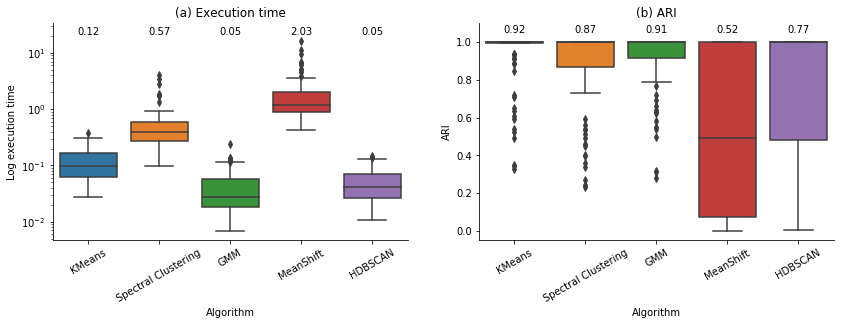

In [6]:
plt.figure(figsize = (14, 4))
ax = plt.subplot(121)
g = sns.boxplot(x = "Algorithm", y = "Execution time", data = r, ax = ax)
g.set_yscale("log")
sns.despine()
means = r.groupby(["clust_id", "Algorithm"]).mean()["Execution time"].values
plt.xticks(rotation = 90)
ylim = ax.get_ylim()
plt.xticks(rotation = 30)
plt.ylim((ylim[0], ylim[1] + 10))
plt.title("(a) Execution time")
plt.ylabel("Log execution time")
for i in range(len(means)):
    plt.text(i-0.15, r["Execution time"].max() + 5, round(means[i], 2) )
sns.despine()



ax = plt.subplot(122)
means = r.groupby(["clust_id", "Algorithm"] ).mean()["ARI"].values
sns.boxplot(x = "Algorithm", y = "ARI", data = r, ax = ax)
plt.xticks(rotation = 30)
plt.title("(b) ARI")
ylim = ax.get_ylim()
plt.ylim((ylim[0], ylim[1] + 0.05))
sns.despine()
for i in range(len(means)):
    plt.text(i-0.15, 1.05, round(means[i], 2) )
plt.savefig(f"../images/cluster_algo_ARI_speed.pdf", bbox_inches='tight')

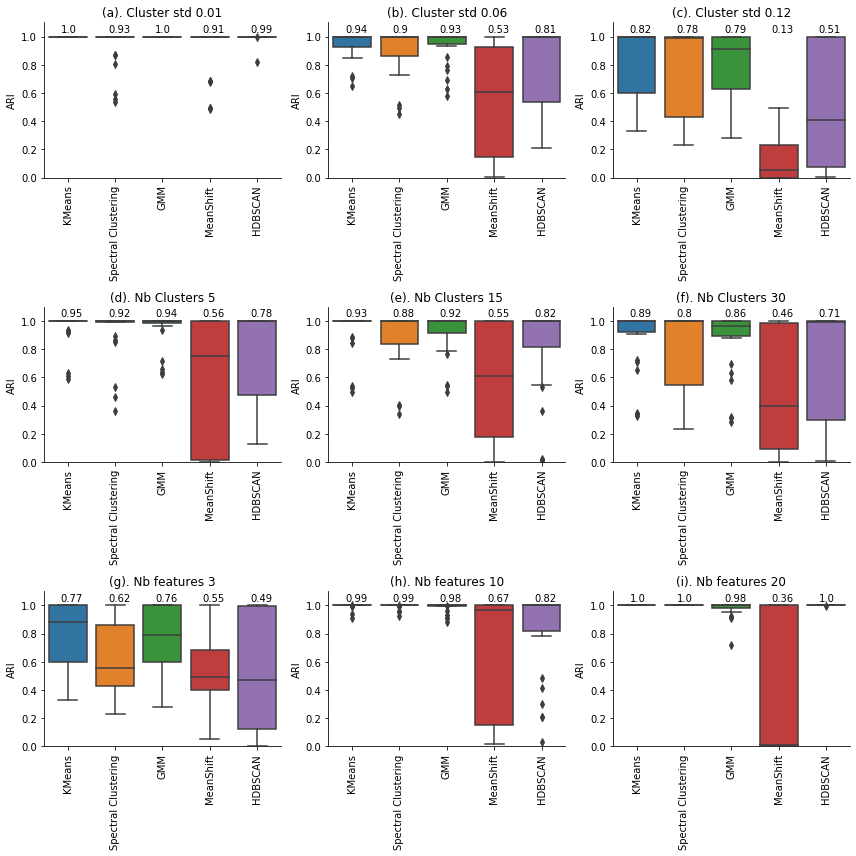

In [8]:
attrs = ["Cluster std", 'Nb Clusters', "Nb features"]
y = "ARI"
plt.figure(figsize =(12, 12))
for j, attr in enumerate(attrs):
    cols = r[attr].unique()

    y_min =r[y].min()
    y_max =r[y].max()
    delta =y_max-y_min

    for i, attr_val in enumerate(cols):
        rs = r[r[attr] == attr_val]

        means = rs.groupby(["clust_id", "Algorithm"]).mean()[y].values

        idx = j * len(attrs) + i+1
        ax = plt.subplot(len(attrs), len(cols), idx)
        g = sns.boxplot(y = y, x = "Algorithm", data = rs, ax = ax)
        plt.ylim(y_min, y_max + delta*0.1)
        plt.xticks(rotation = 90)
        for i in range(len(means)):
            plt.text(i-0.15, y_max +0.03, round(means[i], 2) )
        sns.despine()
        plt.title(f"({letters[idx-1]}). {attr} {attr_val}")
        plt.xlabel("")
plt.tight_layout()

plt.savefig(f"../images/comparative_clustering_performance.pdf", bbox_inches='tight')

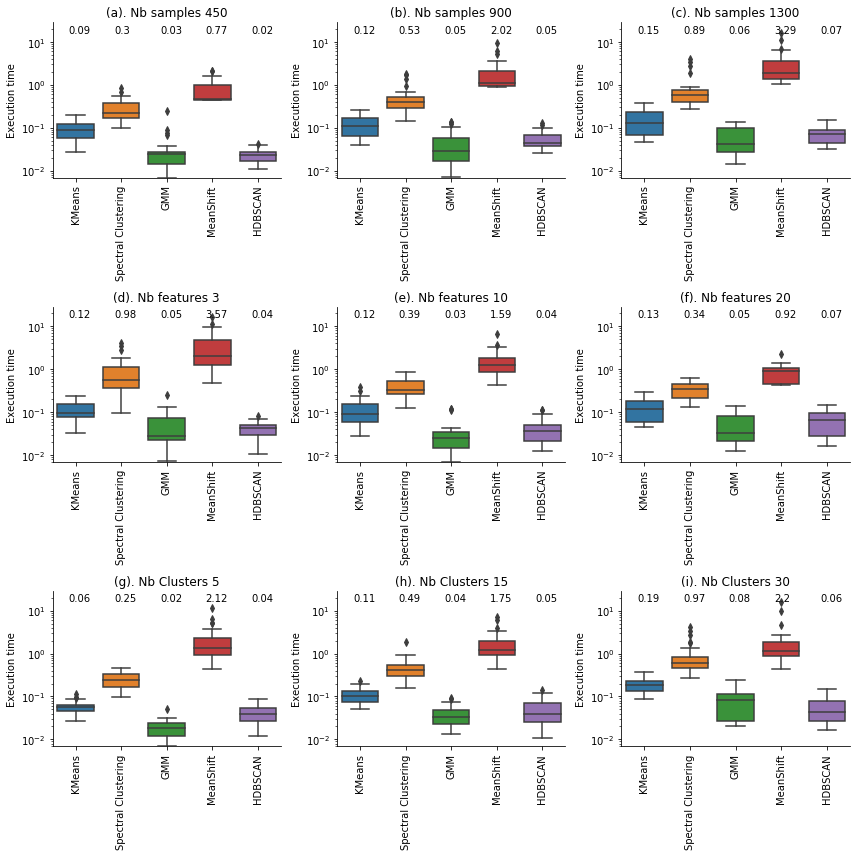

In [9]:
attrs = ['Nb samples', "Nb features", "Nb Clusters"]
y = "Execution time"
plt.figure(figsize =(12, 12))
for j, attr in enumerate(attrs):
    cols = r[attr].unique()

    y_min =r[y].min()
    y_max =r[y].max()
    delta =y_max-y_min

    for i, attr_val in enumerate(cols):
        rs = r[r[attr] == attr_val]

        means = rs.groupby(["clust_id", "Algorithm"]).mean()[y].values

        idx = j * len(attrs) + i+1
        ax = plt.subplot(len(attrs), len(cols), idx)
        g = sns.boxplot(y = y, x = "Algorithm", data = rs, ax = ax)
        plt.ylim(y_min, y_max + delta*0.13)
        plt.xticks(rotation = 90)
        for i in range(len(means)):
            plt.text(i-0.15, y_max +0.05, round(means[i], 2) )
        ylim = ax.get_ylim()
        plt.ylim((ylim[0], ylim[1] + 10))
        sns.despine()
        plt.title(f"({letters[idx-1]}). {attr} {attr_val}")
        plt.xlabel("")
        g.set_yscale("log")
plt.tight_layout()

plt.savefig(f"../images/comparative_clustering_speed.pdf", bbox_inches='tight')

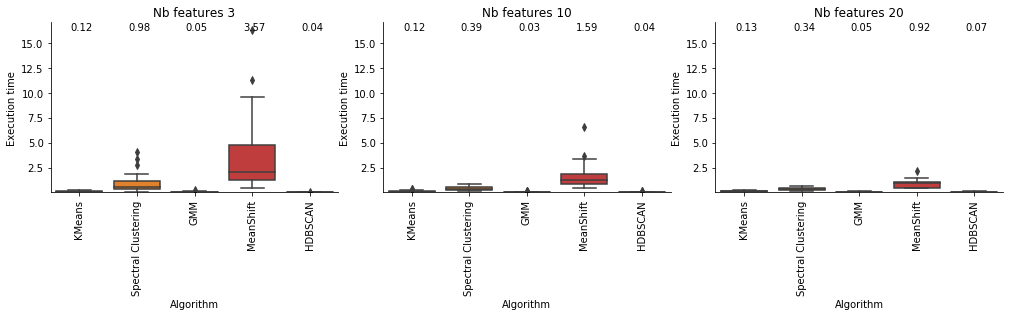

In [10]:
attr = "Nb features"
cols = r[attr].unique()
plt.figure(figsize =(14, 4.5))
y_min =r["Execution time"].min()
y_max =r["Execution time"].max()
delta =y_max-y_min

for i, attr_val in enumerate(cols):
    rs = r[r[attr] == attr_val]

    means = rs.groupby(["clust_id", "Algorithm"]).mean()["Execution time"].values

    ax = plt.subplot(1, len(cols), i+1)
    g = sns.boxplot(y = "Execution time", x = "Algorithm", data = rs, ax = ax)
    plt.ylim(y_min, y_max + delta*0.05)
    plt.xticks(rotation = 90)
    for i in range(len(means)):
        plt.text(i-0.15, y_max, round(means[i], 2) )
    sns.despine()
    plt.title(f"{attr} {attr_val}")
plt.tight_layout()

plt.savefig(f"../images/nb_features_clustering_algo.pdf", bbox_inches='tight')

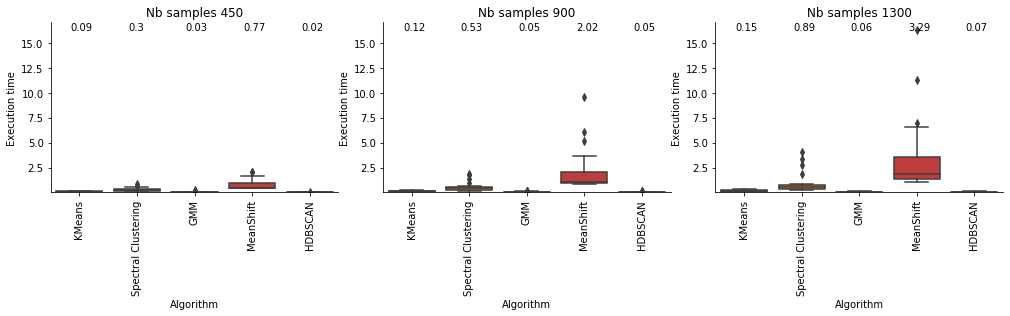

In [11]:
attr = "Nb samples"
cols = r[attr].unique()
plt.figure(figsize =(14, 4.5))
y_min =r["Execution time"].min()
y_max =r["Execution time"].max()
delta =y_max-y_min

for i, attr_val in enumerate(cols):
    rs = r[r[attr] == attr_val]

    means = rs.groupby(["clust_id", "Algorithm"]).mean()["Execution time"].values

    ax = plt.subplot(1, len(cols), i+1)
    g = sns.boxplot(y = "Execution time", x = "Algorithm", data = rs, ax = ax)
    plt.ylim(y_min, y_max + delta*0.05)
    plt.xticks(rotation = 90)
    for i in range(len(means)):
        plt.text(i-0.15, y_max, round(means[i], 2) )
    sns.despine()
    plt.title(f"{attr} {attr_val}")
plt.tight_layout()
plt.savefig(f"../images/nb_samples_clustering_algo.pdf", bbox_inches='tight')

In [12]:
r1 = results[results['Algorithm'] == "GMM"]
def get_text(x):
    if x in [5, 15, 40]:
        return "True k"
    if x in [3, 10, 30]:
        return "Used k < True k"
    if x in [7, 20, 50]:
        return "Used k > True k"
r1["Choice of k"] = r1["k"].apply(get_text)
r1 = r1.rename(columns = {"k": "Used number of clusters"})

r1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Cluster std,subspace,Algorithm,Nb Clusters,Used number of clusters,Silhouette,Davies Bouldin,Ratkovski Lance,ARI,Execution time,Nb features,Nb samples,clust_id,Choice of k
2,0.01,0,GMM,5,3,0.701159,0.574038,0.200565,0.613264,0.007124,3,450,2,Used k < True k
5,0.01,0,GMM,5,5,0.895795,0.148199,0.148939,1.000000,0.010360,3,450,2,True k
8,0.01,0,GMM,5,7,0.711720,0.527980,0.106559,0.866144,0.010965,3,450,2,Used k > True k
14,0.01,1,GMM,15,10,0.784074,0.301232,0.072750,0.643933,0.016291,3,450,2,Used k < True k
17,0.01,1,GMM,15,15,0.894084,0.147239,0.049949,1.000000,0.022602,3,450,2,True k


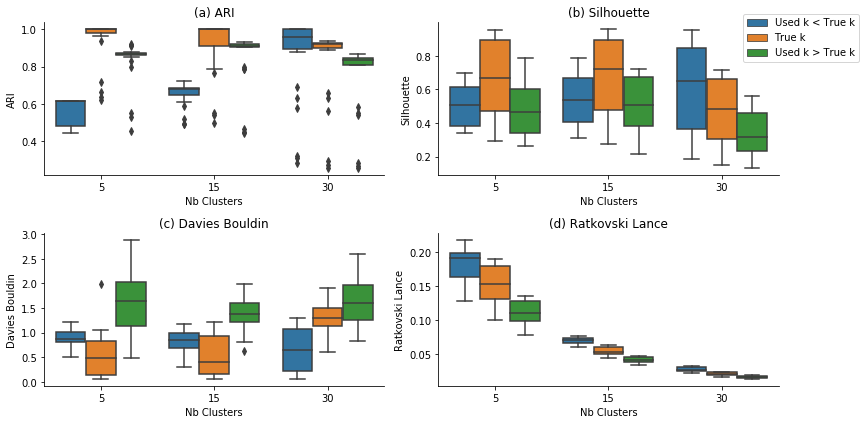

In [13]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(221)
g = sns.boxplot(x = "Nb Clusters", y = "ARI", hue = "Choice of k", data = r1, ax = ax)
plt.title("(a) ARI")
sns.despine()
g.legend_.remove()

ax = plt.subplot(222)
g = sns.boxplot(x = "Nb Clusters", y = "Silhouette", hue = "Choice of k", data = r1, ax = ax)
plt.title("(b) Silhouette")
sns.despine()
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.9), ncol=1)

ax = plt.subplot(223)
g = sns.boxplot(x = "Nb Clusters", y = "Davies Bouldin", hue = "Choice of k", data = r1, ax = ax)
plt.title("(c) Davies Bouldin")
sns.despine()
g.legend_.remove()

ax = plt.subplot(224)
g = sns.boxplot(x = "Nb Clusters", y = "Ratkovski Lance", hue = "Choice of k", data = r1, ax = ax)
plt.title("(d) Ratkovski Lance")
sns.despine()
g.legend_.remove()
plt.tight_layout()
plt.savefig(f"../images/GMM_impact_of_k.pdf", bbox_inches='tight')

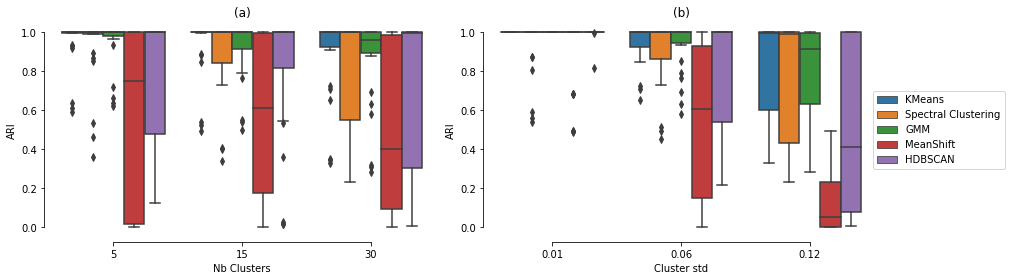

In [15]:
plt.figure(figsize=(14, 4))
ax = plt.subplot(121)
g = sns.boxplot(x = "Nb Clusters", y = "ARI", hue = "Algorithm", data = r, ax = ax)
sns.despine(offset=5, trim=True)
plt.title("(a)")
g.legend_.remove()
# g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax = plt.subplot(122)
g = sns.boxplot(x = "Cluster std", y = "ARI", hue = "Algorithm", data = r, ax = ax)
plt.title("(b)")
sns.despine(offset=5, trim=True)
g.legend(loc='center right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.tight_layout()
plt.savefig(f"../images/cluster_algo_comparison.pdf", bbox_inches='tight')